In [2]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [3]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [4]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [5]:
df = pd.read_csv(INPUT_FILE)

In [5]:
#create a min and a max date
df['mindate'] = df.groupby('wpdx_id')["new_report_date"].transform('min')
df['maxdate'] = df.groupby('wpdx_id')["new_report_date"].transform('max')

In [6]:
df[df.mindate!= df.maxdate].groupby(df.country_name).size().sort_values(ascending=False)

country_name
Uganda                             4985
Afghanistan                        3435
Sierra Leone                       2893
Liberia                            1027
Malawi                              771
Zimbabwe                            665
South Sudan                         274
Bolivia, Plurinational State of     262
Kenya                               200
Nigeria                             112
India                                74
Peru                                 17
Guatemala                            17
Nicaragua                            12
Tanzania, United Republic of         10
Burkina Faso                         10
Rwanda                                8
Honduras                              4
CÌ«te d'Ivoire                        4
Swaziland                             1
dtype: int64

In [6]:
sl = df.loc[df.country_name=='Afghanistan']

In [8]:
sl[sl.mindate!= sl.maxdate].groupby(sl.country_name).size().sort_values(ascending=False)

country_name
Afghanistan    3435
dtype: int64

In [28]:
sl.shape

(59849, 42)

In [32]:
59849 - 58121
print(1728*2)

3456


In [30]:
sl[sl.new_report_date == sl.maxdate].shape

(58121, 42)

In [16]:
sl[sl.wpdx_id == 'wpdx-00134469']

,country_name,water_source,water_tech,status_id,status_0_yes,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech
88343,Afghanistan,Dug Well,__MISSING__,no,1.0,__MISSING__,__MISSING__,DACAAR,1998.0,Water Point Collapsed/ Destroyed|,DACAAR,Kabul,Bagrami,wpdx-00134469,03/02/2014 12:00:00 AM +0000,AF,2934,http://www.dropbox.com/s/9abftmvtim47cso/DACAA...,__MISSING__,__MISSING__,"#status_id, #status, #data_lnk",10/26/2015 11:00:19 PM +0000,10/26/2015 11:00:19 PM +0000,34.5355,69.272,"(34.5355, 69.272)",1.0,NaN,NaN,NaN,2014-03-02,1998-01-01 00:00:00,5904 days 00:00:00.000000000,5904.0,1.0,1467 days 00:00:00.000000000,4.0,16.2,Well,__MISSING__
127507,Afghanistan,__MISSING__,DUG WELL,unknown,1.0,__MISSING__,__MISSING__,DACAAR,1998.0,LOST,DACAAR,Kabul,Bagrami,wpdx-00134469,01/31/2013 12:00:00 AM +0000,AF,__MISSING__,http://www.dropbox.com/s/ju2doouu4f4yzod/DACAA...,__MISSING__,__MISSING__,"#status_id, #source, #country_id, #data_lnk",10/27/2015 12:46:21 AM +0000,10/27/2015 12:46:21 AM +0000,34.5355,69.272,"(34.5355, 69.272)",1.0,NaN,NaN,NaN,2013-01-31,1998-01-01 00:00:00,5509 days 00:00:00.000000000,5509.0,1.0,1862 days 00:00:00.000000000,5.1,15.1,__MISSING__ Unknown,Well


In [7]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [8]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [9]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


0

In [10]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

In [11]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [12]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [13]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [15]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[500,1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [500, 1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
print('model fit for inner CV for Afghanistan')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Afghanistan
Shape of input params=  (35909, 14)
Best searched parameters on inner CV {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best grid score on inner CV 0.799771644992
Accuracy for inner nested_cv model : 0.7997
AUC Score (test) for inner_nested cv_model: 0.847813
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [38]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 500
Accuracy for outer nested_cv model on training data: 0.8628
AUC Score (Train) for outer nested_cv model: 0.931627
AUC Score (Test) for outer nested_cv model: 0.847813
AUC Score (Holdout) for outer nested_cv model: 0.844832
Accuracy for outer nested_cv model on holdout data: 0.8013


In [46]:
metrics.log_loss(y_train.values, dtrain_predprob)

0.32018737238625061

# Fairly stable across test and holdout

In [19]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [20]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.85503182  0.84453028  0.85731301  0.85235034  0.85032999]
Accuracy full-data : 0.8061
AUC Score full-data: 0.851852


(array([ 0.,  0.,  0., ...,  0.,  0.,  1.]), array([[ 0.921242  ,  0.07875799],
        [ 0.83660638,  0.1633936 ],
        [ 0.94750404,  0.05249597],
        ..., 
        [ 0.68416667,  0.3158333 ],
        [ 0.92688787,  0.07311212],
        [ 0.25241506,  0.74758494]], dtype=float32))

In [21]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [22]:
name = sl.country_name.unique()[0]
save_model(model_outer, name)

saved as Afghanistan_pickle.sav


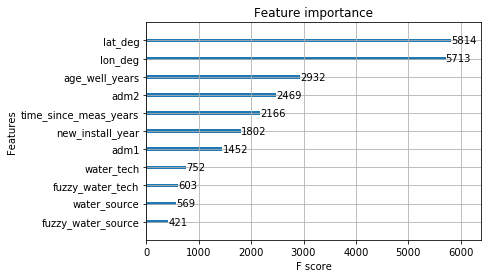

In [23]:
xgb.plot_importance(model_outer)

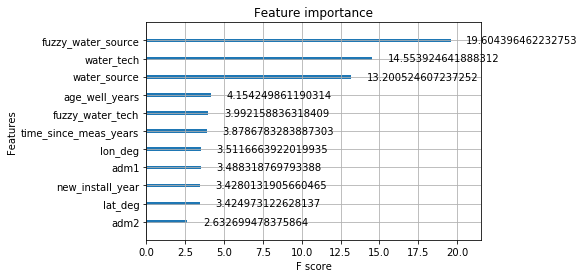

In [39]:
xgb.plot_importance(model_outer, importance_type='gain')

In [44]:
model_outer.feature_importances_

array([ 0.02304297,  0.03045397,  0.        ,  0.        ,  0.05880209,
        0.09998785,  0.        ,  0.23545134,  0.23136112,  0.07297615,
        0.11873811,  0.08771717,  0.01704937,  0.02441988], dtype=float32)

In [47]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

In [35]:
# from eli5.sklearn import PermutationImportance
# perm = PermutationImportance(model_outer).fit(X_test, y_test)
# eli5.show_weights(perm)

In [57]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

In [59]:
imp

array([-0.0141246 , -0.06715192,  0.        ,  0.        , -0.00920372,
       -0.01360297,  0.        , -0.02340217, -0.03914851, -0.02613135,
       -0.03557804, -0.02551007, -0.02159273, -0.01877334])

In [60]:
X_test.columns

Index(['water_source', 'water_tech', 'management', 'source', 'adm1', 'adm2',
       'pay', 'lat_deg', 'lon_deg', 'new_install_year', 'age_well_years',
       'time_since_meas_years', 'fuzzy_water_source', 'fuzzy_water_tech'],
      dtype='object')

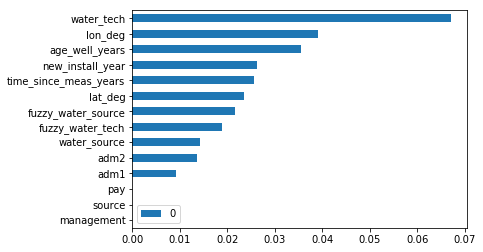

In [65]:
pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0).plot(kind='barh')

In [89]:
sl.groupby('water_tech')['status_binary'].agg(['mean','count']).sort_values(by='count', ascending=False)

,mean,count
water_tech,,
DUG WELL,0.320935,20568
INDUS,0.262298,12543
__MISSING__,0.537549,9268
TUBE WELL,0.104097,6321
PAMIR,0.239720,4718
KABUL,0.321980,3435
STAND POST,0.024853,2897
Lorentz,0.123711,97
RAIN WATER,0.000000,2


# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

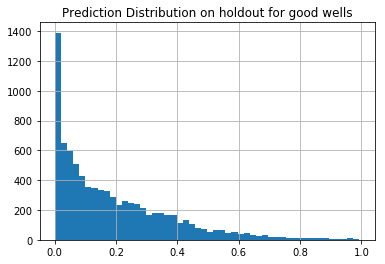

In [66]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


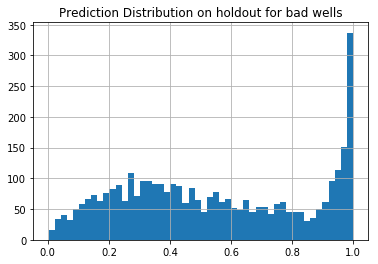

In [67]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 0.21351357,  0.52816515,  0.53940271,  0.65177827,  0.80910406,
         0.95519229,  1.09004297,  0.93271718,  1.17994342,  0.96642985,
         1.42716966,  1.10128053,  1.25860632,  1.51707011,  1.16870586,
         1.10128053,  1.26984387,  1.02261763,  1.07880541,  0.97766741,
         0.74167872,  0.98890496,  1.00014252,  0.8765294 ,  0.80910406,
         0.68549094,  0.71920361,  0.74167872,  0.73044117,  0.64054071,
         0.93271718,  0.64054071,  0.60682804,  0.58435293,  0.47197737,
         0.66301583,  0.91024207,  1.57325789,  1.71934613,  4.3039841 ]),
 array([ 0.00229134,  0.02721078,  0.05213022,  0.07704966,  0.1019691 ,
         0.12688854,  0.15180798,  0.17672742,  0.20164686,  0.2265663 ,
         0.25148574,  0.27640518,  0.30132462,  0.32624406,  0.35116349,
         0.37608293,  0.40100237,  0.42592181,  0.45084125,  0.47576069,
         0.50068013,  0.52559957,  0.55051901,  0.57543845,  0.60035789,
         0.62527733,  0.65019677,  0.67511621,  0

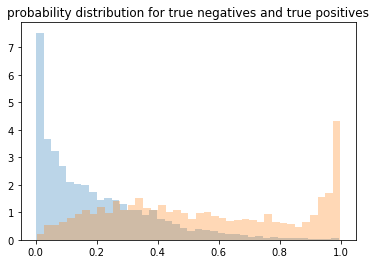

In [68]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### Some separation, will need to adjust the threshold

In [90]:
def evaluate_prediction_thresholds(y_true, y_pred_probs, recall_val):
    import numpy as np
    d = dict()
    for i in np.linspace(0,0.5, num=20):
        best = 0
        test = np.where(y_pred_probs > i, 1,0)
        recall = metrics.recall_score(y_true, test)
        precision = metrics.precision_score(y_true, test)
        f_score = metrics.f1_score(y_true, test, average='binary')
        d[i]=recall, precision, f_score

    frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
    frame.columns=(['recall','precision', 'f1_score'])
    frame = frame[frame.recall>recall_val]
    return frame

In [91]:
evaluate_prediction_thresholds(y_test, dtest_predprob, .7)

,recall,precision,f1_score
0.000000,1.000000,0.298246,0.459459
0.026316,0.991877,0.340874,0.507379
0.052632,0.983473,0.366531,0.534033
0.078947,0.966947,0.392496,0.558350
0.105263,0.945378,0.418319,0.579997
0.131579,0.927171,0.441098,0.597797
0.157895,0.901681,0.461836,0.610816
0.184211,0.876751,0.482801,0.622700
0.210526,0.851541,0.504900,0.633928
0.236842,0.821569,0.526099,0.641443


In [92]:
evaluate_prediction_thresholds(y_holdout, dholdout_predprob, 0.7)

,recall,precision,f1_score
0.000000,1.000000,0.298329,0.459559
0.026316,0.994679,0.343188,0.510308
0.052632,0.980958,0.368931,0.536201
0.078947,0.967236,0.395375,0.561307
0.105263,0.948474,0.417478,0.579767
0.131579,0.927191,0.436750,0.593795
0.157895,0.901428,0.457634,0.607072
0.184211,0.874825,0.478407,0.618553
0.210526,0.848502,0.497782,0.627459
0.236842,0.813498,0.517272,0.632415


## Modeling Decision: Threshold of 0.237 gives a recall > 0.81 and a precision > 0.51 on both test and holdout. Will use as threshold. Not great but want to have at least a 50% chance of investigating a real bad well (prioritization) and balanced with catching as many as possible (recall).

### Create predictions for the out years based on data.  Had to correct X_today time since measurment, as initial predictions didn't adjust time since measurement in X_Today.

In [14]:
model_outer=pickle.load(open('Afghanistan_pickle.sav', 'rb'))

In [15]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
82,7,0,0,0,18,193,0,33.5244,69.7361,18,17.2,11.3,3,6


In [17]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4


In [18]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today[['age_well_years', 'time_since_meas_years']][:1])
print(X_1year[['age_well_years', 'time_since_meas_years']][:1])
print(X_3year[['age_well_years', 'time_since_meas_years']][:1])
print(X_5year[['age_well_years', 'time_since_meas_years']][:1])

    age_well_years  time_since_meas_years
82             5.9                   11.3
    age_well_years  time_since_meas_years
82            17.2                   11.3
    age_well_years  time_since_meas_years
82            18.2                   11.3
    age_well_years  time_since_meas_years
82            20.2                   11.3
    age_well_years  time_since_meas_years
82            22.2                   11.3


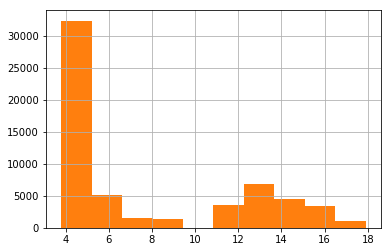

In [19]:
plt.subplots()
X_today.time_since_meas_years.hist()
X2.time_since_meas_years.hist()

# Get Predictions for Today, 1, 3 and 5 years out

In [20]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [21]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [76]:
#Original, before the correction to time since measurement was corrected for X_today
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,59849.000000,59849.000000,59849.000000,59849.000000,59849.000000
mean,0.298284,0.265735,0.241558,0.200789,0.190329
std,0.457509,0.441728,0.428031,0.400594,0.392564
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
#With corrected time since measurement, but still default 0.5 threshold
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,59849.000000,59849.000000,59849.000000,59849.000000,59849.000000
mean,0.298284,0.265735,0.268409,0.273254,0.277298
std,0.457509,0.441728,0.443135,0.445634,0.447669
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of 0.237 for our prediction threshold

# Also coerce well status to be "broken" if it was ever "broken" in the past. Should have excluded non functioning wells from prior predictions

In [23]:
threshold = 0.237
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [24]:
afg = df.loc[df.country_name=='Afghanistan']

In [133]:
#ORIGINAL, without corrected time_since_meas
coerced = append_outyear_predictions(afg, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [134]:
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,59849.000000,59849.00000,59849.000000,59849.000000,59849.000000
mean,0.298284,0.60006,0.637371,0.676703,0.718007
std,0.457509,0.48989,0.480763,0.467739,0.449974
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,1.00000,1.000000,1.000000,1.000000
75%,1.000000,1.00000,1.000000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000


In [25]:
#Corrected with Correct timne since_meas
coerced2 = append_outyear_predictions(afg, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [26]:
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,59849.000000,59849.00000,59849.000000,59849.000000,59849.000000
mean,0.298284,0.60006,0.616869,0.631305,0.639392
std,0.457509,0.48989,0.486154,0.482455,0.480181
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,1.00000,1.000000,1.000000,1.000000
75%,1.000000,1.00000,1.000000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000


In [27]:
#check to see if it worked
sl[(sl.status_binary==1)&(sl.status_binary<sl.today_preds)].shape

(0, 23)

In [28]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
coerced2[coerced2.status_binary==0][(coerced2.today_preds==1)].shape

(18061, 48)

In [29]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
print(sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].shape)
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].tail(10)

(341, 23)


,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech,status_binary,today_preds,today_predprob,one_year_preds,one_year_predprob,three_year_preds,three_year_predprob,five_year_preds,five_year_predprob
127302,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.4506,69.2185,1998-01-01 00:00:00,13.7,6.4,__MISSING__ Unknown,Well,0.0,0.0,0.491322,1.0,0.506131,1.0,0.518063,1.0,0.518063
127455,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Paghman,__MISSING__,34.5168,68.9977,2004-01-01 00:00:00,5.8,8.4,__MISSING__ Unknown,Well,0.0,0.0,0.483285,1.0,0.532303,0.0,0.499181,1.0,0.548186
127474,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.4945,69.2754,1998-01-01 00:00:00,13.8,6.4,__MISSING__ Unknown,Tube Well,0.0,0.0,0.491727,1.0,0.506537,1.0,0.518468,1.0,0.518468
127496,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5242,69.3245,1998-01-01 00:00:00,13.8,6.4,__MISSING__ Unknown,Well,0.0,0.0,0.495320,1.0,0.510130,1.0,0.522056,1.0,0.522056
127504,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5003,69.1833,1998-01-01 00:00:00,15.1,5.1,__MISSING__ Unknown,Well,0.0,0.0,0.493314,1.0,0.513133,1.0,0.525054,1.0,0.525054
127565,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kabul,Dih Sabz,__MISSING__,34.7040,69.2244,2002-01-01 00:00:00,11.0,5.2,__MISSING__ Unknown,Tube Well,0.0,0.0,0.497938,1.0,0.635162,1.0,0.585193,1.0,0.620985
127639,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5167,69.3120,1998-01-01 00:00:00,13.8,6.4,__MISSING__ Unknown,Well,0.0,0.0,0.489201,1.0,0.504011,1.0,0.515944,1.0,0.515944
127645,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5167,69.3120,1998-01-01 00:00:00,12.2,8.0,__MISSING__ Unknown,Well,0.0,0.0,0.493865,1.0,0.508675,1.0,0.520603,1.0,0.520603
128622,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7925,69.6648,2002-01-01 00:00:00,1.8,14.4,__MISSING__ Unknown,Well,0.0,0.0,0.496565,1.0,0.510344,1.0,0.550891,1.0,0.562815
128667,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8429,69.6632,2004-01-01 00:00:00,2.1,12.1,__MISSING__ Unknown,Well,0.0,0.0,0.498774,1.0,0.519324,0.0,0.491376,1.0,0.518198


In [30]:
sl[sl.status_binary==0][(sl.today_preds<sl.three_year_preds)].tail(10)

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech,status_binary,today_preds,today_predprob,one_year_preds,one_year_predprob,three_year_preds,three_year_predprob,five_year_preds,five_year_predprob
127510,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kabul,Dih Sabz,__MISSING__,34.6047,69.2221,2003-01-01 00:00:00,10.0,5.2,__MISSING__ Unknown,Tube Well,0.0,0.0,0.435208,0.0,0.446357,1.0,0.542729,1.0,0.564566
127550,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.4972,69.1792,1998-01-01 00:00:00,15.1,5.1,__MISSING__ Unknown,Well,0.0,0.0,0.469512,0.0,0.489298,1.0,0.501236,1.0,0.501236
127565,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kabul,Dih Sabz,__MISSING__,34.7040,69.2244,2002-01-01 00:00:00,11.0,5.2,__MISSING__ Unknown,Tube Well,0.0,0.0,0.497938,1.0,0.635162,1.0,0.585193,1.0,0.620985
127639,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5167,69.3120,1998-01-01 00:00:00,13.8,6.4,__MISSING__ Unknown,Well,0.0,0.0,0.489201,1.0,0.504011,1.0,0.515944,1.0,0.515944
127645,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kabul,Bagrami,__MISSING__,34.5167,69.3120,1998-01-01 00:00:00,12.2,8.0,__MISSING__ Unknown,Well,0.0,0.0,0.493865,1.0,0.508675,1.0,0.520603,1.0,0.520603
127927,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kandahar,Daman,__MISSING__,31.5330,65.8121,1999-01-01 00:00:00,5.0,14.2,__MISSING__ Unknown,Tube Well,0.0,0.0,0.495636,0.0,0.498115,1.0,0.503324,1.0,0.503324
128622,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7925,69.6648,2002-01-01 00:00:00,1.8,14.4,__MISSING__ Unknown,Well,0.0,0.0,0.496565,1.0,0.510344,1.0,0.550891,1.0,0.562815
128623,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8703,69.6475,2002-01-01 00:00:00,2.1,14.1,__MISSING__ Unknown,Well,0.0,0.0,0.459465,0.0,0.473181,1.0,0.513875,1.0,0.525935
128626,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8732,69.6623,2002-01-01 00:00:00,2.1,14.1,__MISSING__ Unknown,Well,0.0,0.0,0.459465,0.0,0.473181,1.0,0.513875,1.0,0.525935
128627,__MISSING__,DUG WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7084,69.6776,2002-01-01 00:00:00,4.1,12.1,__MISSING__ Unknown,Well,0.0,0.0,0.468393,0.0,0.482138,1.0,0.508961,1.0,0.521030


In [135]:
#outputting with consistent failed wells coerced over time
coerced.to_csv('Afghanistan_w_outyear_predictions_coerced.csv')

In [32]:
#outputting with consistent failed wells coerced over time and correct time_since_measurement_preds
coerced2.to_csv('Afghanistan_w_outyear_predictions_coerced_correct_time2.csv')

In [ ]:
out.